In [1]:
from ex1_Camera_projection import box3d, projectpoints
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
from numba import jit 
import logging;
logging.disable(logging.WARNING)
from scipy.spatial.transform import Rotation

Defining some global parameters

In [2]:
f = 1000
dx = 300
dy = 200
K1 = K2 = np.array([[f, 0, dx], [0, f, dy], [0, 0, 1]])

R1 = np.identity(3)
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()

t1 = np.array([[0, 0, 0]]).T
t2 = np.array([[0.2, 2, 1]]).T

### 3.1 Projections

In [3]:
def projectpoints_new(K, R, t, Q):
    """
    Projects 3D points of an object to the 2D image plane of the camera.
    Using homogenous coordinates the process can be done like this:
            p_h = K*[R t]*P_h

    Parameters:
        - K: camera matrix - hold intrinsic camera info like focault distance and principal points
        - R, t: pose of camera transformation; scale and transport object to the camera plane.
        - Q: 3xn the n 3D points to be projected onto image plane.
    
    Returns: 2xn matrix of projected points
    """
    
    # First creates the [R t] Matrix
    A = np.hstack((R, t))
    # Then, translate Q to homogenous plane => 4xn matrix by adding s=1
    #B = np.vstack((Q, np.ones(len(Q[0]))))
    B = Q
    # Solve the projection in homogenous plane 
    p_h = K@A@B
    # Translate back to cartesian coordinates and return (divide all by s, then remove s)
    p = p_h[0:2, :]/p_h[2, :]
    return p_h, p

In [4]:
Q = np.array([[1, 0.5, 4, 1]]).T
q1, p1 = projectpoints_new(K1, R1, t1, Q)
q2, p2 = projectpoints_new(K2, R2, t2, Q)

In [5]:
print(p1,"\n", p2)

[[550.]
 [325.]] 
 [[582.47256835]
 [185.98985776]]


### 3.2 Crossop


In [6]:
def crossOp(p):
    """
    returns is a 3x3 matrix, corresponding to taking crossproduct of p.
    [p]_x = CrossOp(p)
    """
    return np.array([
        [0, -p[2], p[1]],
        [p[2], 0, -p[0]],
        [-p[1], p[0], 0]], dtype=type(p[0][0]))

p = np.array([[3, 4, 5]]).T
print(crossOp(p))

[[ 0 -5  4]
 [ 5  0 -3]
 [-4  3  0]]


### 3.3 Fundemental matrices
F = inv(K2).T @ E @ inv(K1)

E = [t]_x * R 

In [7]:
def fundamental(R, t, K1, K2):
    """
    The R and t relates the two cameras.
    K1 and K2 for each camera.
    Returns the F which relates the camera on the pixel plane.
    """
    E = crossOp(t)@R
    return (np.linalg.inv(K2)).T @ E @ (np.linalg.inv(K1))


In [8]:
F = fundamental(R2, t2, K1, K2)
F

array([[ 3.29311881e-07,  8.19396327e-07,  1.79162592e-03],
       [ 5.15532551e-07, -8.76915984e-07,  9.31426656e-05],
       [-1.29882755e-03,  1.51951700e-03, -1.10072682e+00]])

### 3.4 Epipolar lines

F is what relates a point on one image plane to a line on the other. l2 = Fq1. 

Also, q2.T@F@q1 = 0, as q2 is on the epiploar line itself.

In [9]:
def epipolar_line(F, q1):
    # returns epipolar line of q1 in camera 2
    return F@q1

In [10]:
l2 = epipolar_line(F, q1)

In [11]:
l2

array([[ 8.95620504e-03],
       [ 3.66751496e-04],
       [-5.28495581e+00]])

### 3.5 On the line?

q2 must be on the line, as F is defined as q2.T @F@ q1 = 0.

To check if a point is on a line we can use q.T@l = 0, or q@l.T = 0...

q2 and l2 are both derived from the same 3D point Q, which yields a single epipolar plane, yielding a line in each camera. The points on one epiploar line must be found in the other, given perfect F matrix.

In [12]:
print((q2.T@l2)[0][0])

8.000105582412339e-15


### 3.6 Different R and t
Both cam1 and cam2 have coordinates different from world coordinates.

$Q_{tilde} = \begin{bmatrix}
R_1 & t_1 \\
0 & 1 
\end{bmatrix} Q$ 

It can be shown that:

$ Q = \begin{bmatrix}
R_1^T & -R_1^T t_1 \\
0 & 1 
\end{bmatrix} Q_{tilde}$ 


This is a standard translation and rotation, with homogenous input and output.
See book for calculations.

### 3.7 Projection
Show that we can work only in the coordinate system of camera one, by showing that we can
project points with

$q_1 = K \begin{bmatrix} I & 0 \end{bmatrix} Q_{tilde}$ and $q_2 = K \begin{bmatrix} R_2^{tilde} & t_2^{tilde} \end{bmatrix} Q_{tilde}$

- $R_2^{tilde} = R_2 R_1^T$ 

- $t_2^{tilde} = t_2 - R_2 R_1^T t_1$


-> The idea is to treat Cam1's coordinates as the global coordinates, and rotate / translate cam2 accordingly. 


### 3.8 Apply epipolar geometry

In [13]:
two_image_data = np.load('TwoImageData.npy', allow_pickle=True).item()

gray_left = two_image_data["im1"]
gray_right = two_image_data["im2"]

R1 = two_image_data["R1"]
R2 = two_image_data["R2"]

t1 = two_image_data["t1"]
t2 = two_image_data["t2"]

K1 = two_image_data["K"]
K2 = K1.copy()




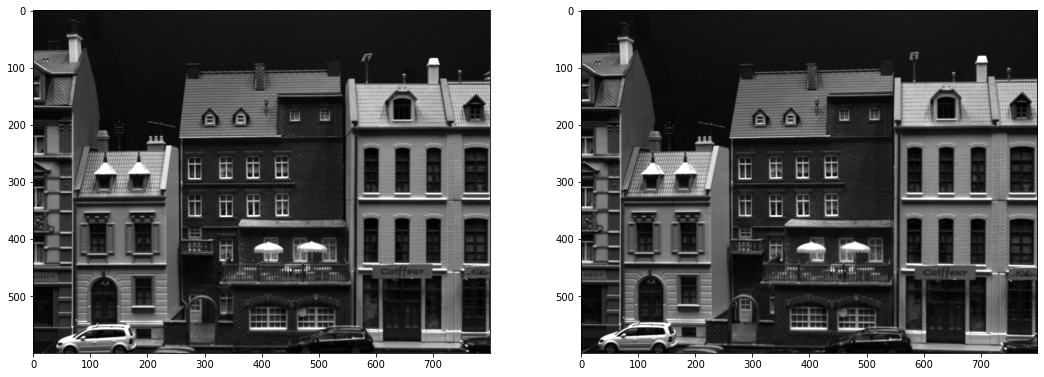

In [14]:
f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
ax_left.imshow(gray_left, cmap="gray")
ax_right.imshow(gray_right, cmap="gray")

Fundemental matrix between the two:
- Notice that now that R1 == I, and t1 == 0!
- We therefor do not actually need to do the tricks we learned in the previous exercise! :0

In [15]:
Rtilde = R2@R1.T # = R2...
ttilde = t2 - R2@R1.T@t1 # = t2...

F = fundamental(Rtilde, ttilde, K1, K2)
F

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

### 3.9 Epipolar lines display

In [16]:
def DrawLine(l, shape, ax):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    ax.plot(*np.array(P).T, c="r")


In [17]:
def click_epiline(img1, img2, F):
    # We need to turn off the matplotlib inline to use ginput.
    %matplotlib qt
    # Extract one inhomogenous point p in left image.
    plt.imshow(img1)
    x = plt.ginput(1) # one input
    plt.show()

    # Translate point to homogenous coordinates
    p1 = np.array(x).reshape(2, 1)
    q1 = np.vstack((p1, np.ones(1)))

    # Use F-matrix to get the epipolar line of other camera.
    l2 = epipolar_line(F, q1)

    # Return to inline plotting
    %matplotlib inline
    f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
    # left
    ax_left.imshow(img1, cmap="gray")
    ax_left.plot(p1[0], p1[1], 'ro')
    # right
    ax_right.imshow(img2, cmap="gray")
    DrawLine(l2, img2.shape, ax_right)
    # display
    plt.show()

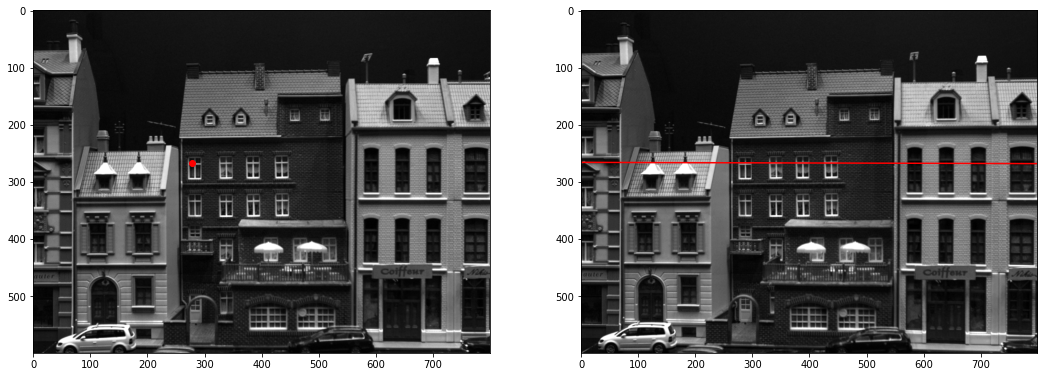

In [18]:
click_epiline(gray_left, gray_right, F)

### 3.10, opposite day!

- Go from img2 --> img1 instead
- Luckily, F gives a pretty easy transition between the two! 

$l_2 = F q_1$ and $l_1 = F^T q_2$

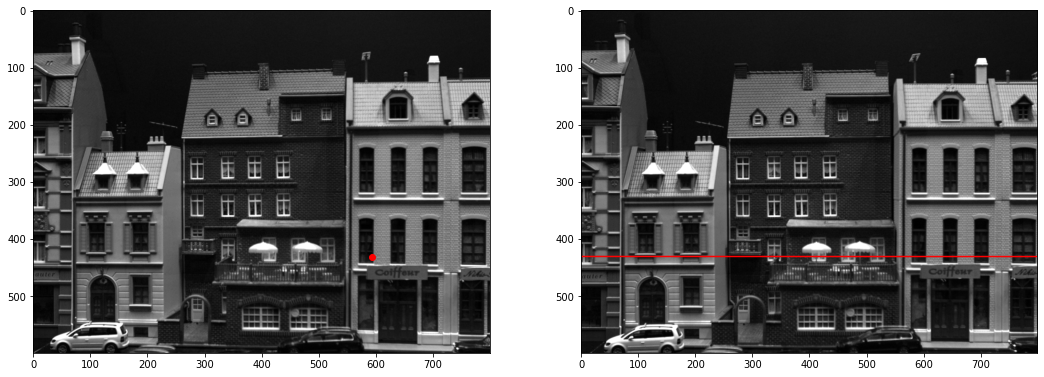

In [19]:
click_epiline(gray_right, gray_left, F.T)

### 3.11 Triangulation

- Using the pixel coordinates q1, q2, ..., qn we want to find the position of the points in 3D.
- use the linear algorithm presented at the end of lecture

In [20]:
def triangulate(q, P):
    """
    Return the traingulation.
    
    Parameters
    ----------
    q: 3 x n numpy array
        Homogenous pixel coordinates q1... qn
        One for each camera seeing the point.
        At least two.
    P: list of 3 x 4 numpy arrays
        Projection matrices P1... Pn
        For each pixel coordinate
    
    Return
    ------
    Q: 3 x 1 numpy array
        Triangulation of the point using the linear SVD algorithm
    """
    _, n = q.shape # n = no. cameras has seen pixel.

    # Prepare B matrix. Two rows for each camera n.
    B = np.zeros((2 * n, 4))
    for i in range(n):
        B[2 * i: 2 * i + 2] = [
            P[i][2, :] * q[0, i] - P[i][0, :],
            P[i][2, :] * q[1, i] - P[i][1, :],
        ]
    # BQ = 0. Minimize using Svd.
    _, _, vh = np.linalg.svd(B)
    Q = vh[-1, :] # Q is ev. corresponding to the min. singular point.
    return Q[:3].reshape(3, 1) / Q[3] # Reshape and scale.

Q = np.array([4, 6, 2]).reshape(3, 1) # Reshape to column matrix.

# Make the projection matrixes for both cameras.
P1 = K1 @ np.hstack([R1, t1])
P2 = K2 @ np.hstack([R2, t2])

# Aquire the pixel points in each camera, using function from ex1.
q1 = projectpoints(K1, R1, t1, Q)
q2 = projectpoints(K2, R2, t2, Q)

print("Actual Q:\n", Q, "\n-----------")
print("Q projected:\n", triangulate(np.hstack((q1, q2)), [P1, P2]))

Actual Q:
 [[4]
 [6]
 [2]] 
-----------
Q projected:
 [[4.]
 [6.]
 [2.]]
